In [4]:
import gmplot

<IPython.core.display.Javascript object>


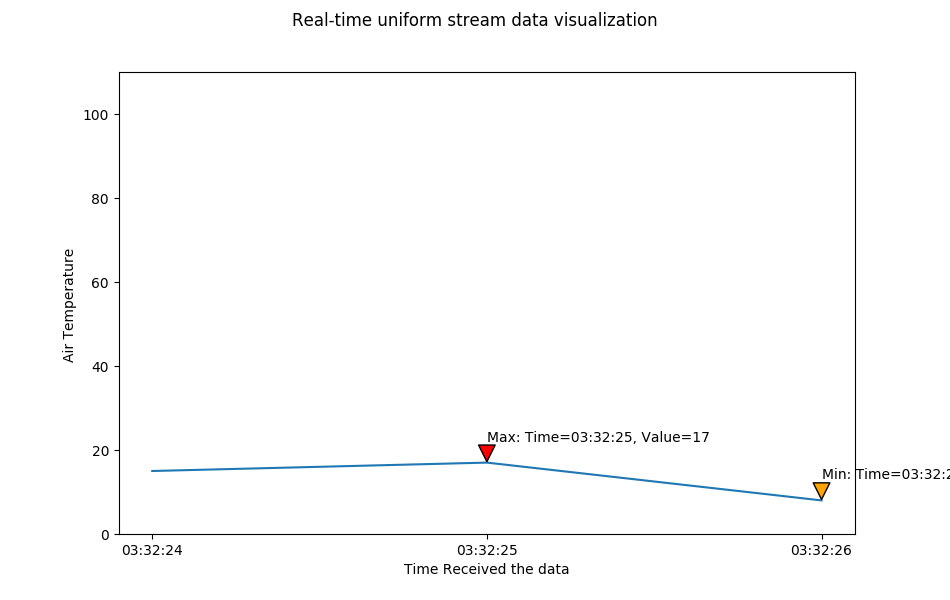

KeyboardInterrupt: 

In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'taskc'

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=100000000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='smallest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

    
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('ascii'))
            my_data = json.loads(data)
            my_data = my_data.replace("'","\"")
            my_data = json.loads(my_data)
            air_temp = str(my_data["air_temperature_celcius"])
            time_now = str(dt.datetime.now().strftime("%X"))
            #time_now = str(my_data["timestamp"])
            producer = str(my_data["sender_id"])
            #print("air temp is",air_temp)
            #print("time now  is",time_now)
            #print("Sender ID is",producer)

            x.append(time_now) 
            y.append(int(air_temp))
            # print(y)
            # we start plotting only when we have 10 data points
            if len(y) > 2:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time Received the data')
                ax.set_ylabel('Air Temperature ')
                ax.set_ylim(0,110) 
                ax.set_yticks([0,20,40,60,80,100])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)